In [1]:
import os
import sys

# change to upper dir to use all custom libs (won't be needed if run from main scripts)
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import torch
from scripts.helpers.model_manager import Madlad400Model

model = Madlad400Model(device='cpu')

# model.translate_batch(['Счастливые лисички прыгают прыг скок', 'раз два три!'], 'ru', 'kaz')

### Get lang -> tokens distribution based on small subsample of Flores+

In [3]:
from datasets import load_dataset

flores = load_dataset("openlanguagedata/flores_plus")['dev'].to_pandas()
flores.head()

Resolving data files:   0%|          | 0/218 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/213 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/218 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/213 [00:00<?, ?it/s]

,id,iso_639_3,iso_15924,glottocode,text,url,domain,topic,has_image,has_hyperlink,last_updated
0,0,ace,Arab,achi1257,يق أورو سنين، اوق علمون دري فکولتس کدوکترن يون...,https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
1,1,ace,Arab,achi1257,ڤنليتي اوتام خن اترا ڽو موڠکين محسى ديتيکسي فو...,https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
2,2,ace,Arab,achi1257,جاس ۳۹سي ݢريڤين مڤوق لندسن ڤاچو ليڠک ڤوه ۹:۳۰ ...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
3,3,ace,Arab,achi1257,ڤيلوت ݢکالون ايدنتيتس سباݢو کڤالا سکوادرون ديل...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
4,4,ace,Arab,achi1257,مديا دي سينن ݢڤتهى سابوه کندراءن ڤمادم اڤوي بن...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0


In [4]:
from collections import Counter, defaultdict
from tqdm import tqdm

combined = defaultdict(Counter)
for row in tqdm(flores.to_dict('records')):
    combined[row['iso_639_3']] += Counter(model.tokenizer(row["text"])['input_ids'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 217346/217346 [01:29<00:00, 2426.60it/s]


In [5]:
def unflatten(cnt: Counter, skip_key: lambda k: False, skip_val = lambda v: False):
    for key, val in cnt.items():
        if skip_key(key):
            continue
        if skip_val(val):
            continue
        for _ in range(val):
            yield key

VVV useless VVV

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:16<00:00, 12.09it/s]
C:\Users\cutefluffyfox\AppData\Local\Temp\ipykernel_19472\3952392570.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


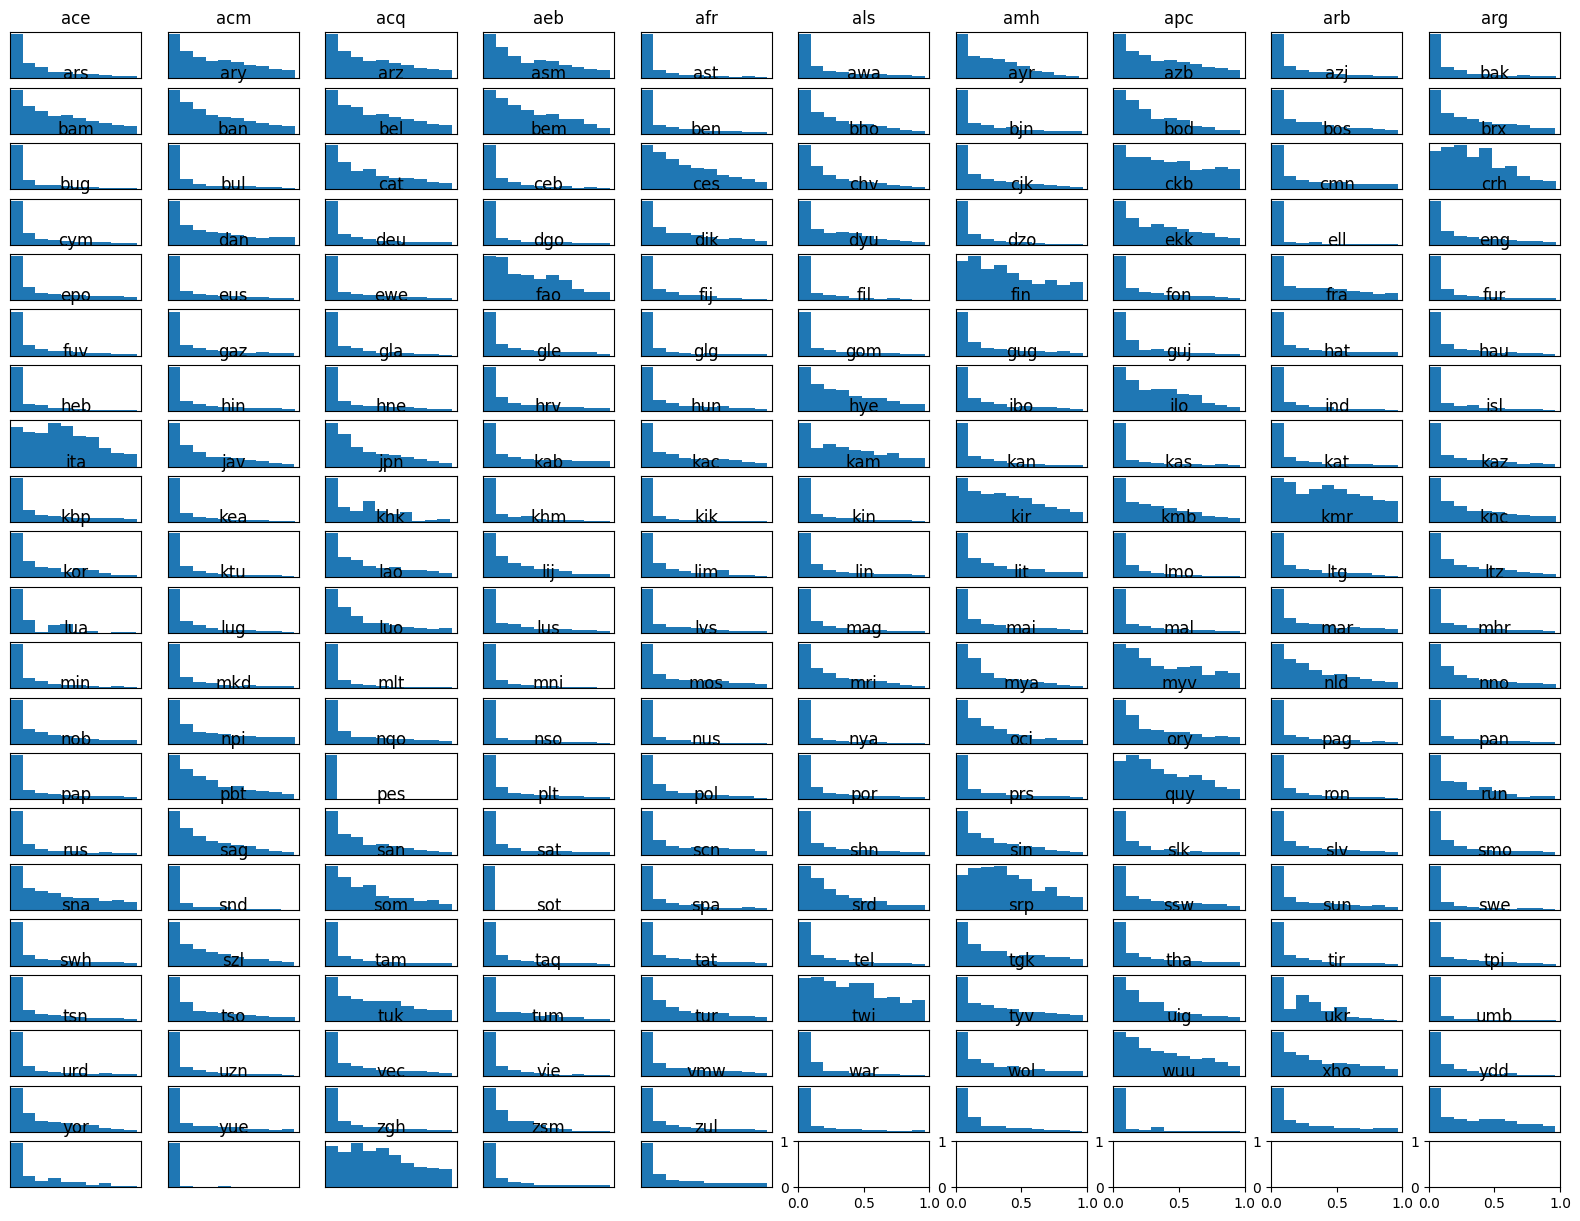

In [6]:
import matplotlib.pyplot as plt

shape = (21, 10)
fig, axs = plt.subplots(shape[0], shape[1], figsize=(20, 15))

for idx, key in tqdm(enumerate(combined.keys()), total=len(combined.keys())):
    ax = axs[idx // shape[1], idx % shape[1]]
    ax.set_xlim([0, 256_000-1])
    ax.hist(list(unflatten(combined[key], skip_key=lambda k: len(model.tokenizer.decode(k)) <= 2)))
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_title(key)

fig.show()
# combined.keys()

In [7]:
def counter_based_iou(cnt1: Counter, cnt2: Counter):
    cnt1['NON-ZERO-DIVISION'] = 1
    cnt2['NON-ZERO-DIVISION'] = 1
    
    intersection = cnt1 & cnt2
    union = cnt1 | cnt2
    return sum(intersection.values()) / sum(union.values())

In [8]:
# import matplotlib.pyplot as plt

# shape = (205, 205)
# fig, axs = plt.subplots(shape[0], shape[1], figsize=(15, 15))

# langs = list(combined.keys())
# for i, lang1 in enumerate(tqdm(langs)):
#     for j, lang2 in enumerate(langs):
#         axs[i, j].

# fig.show()
# # combined.keys()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [02:29<00:00,  1.37it/s]


<Axes: >

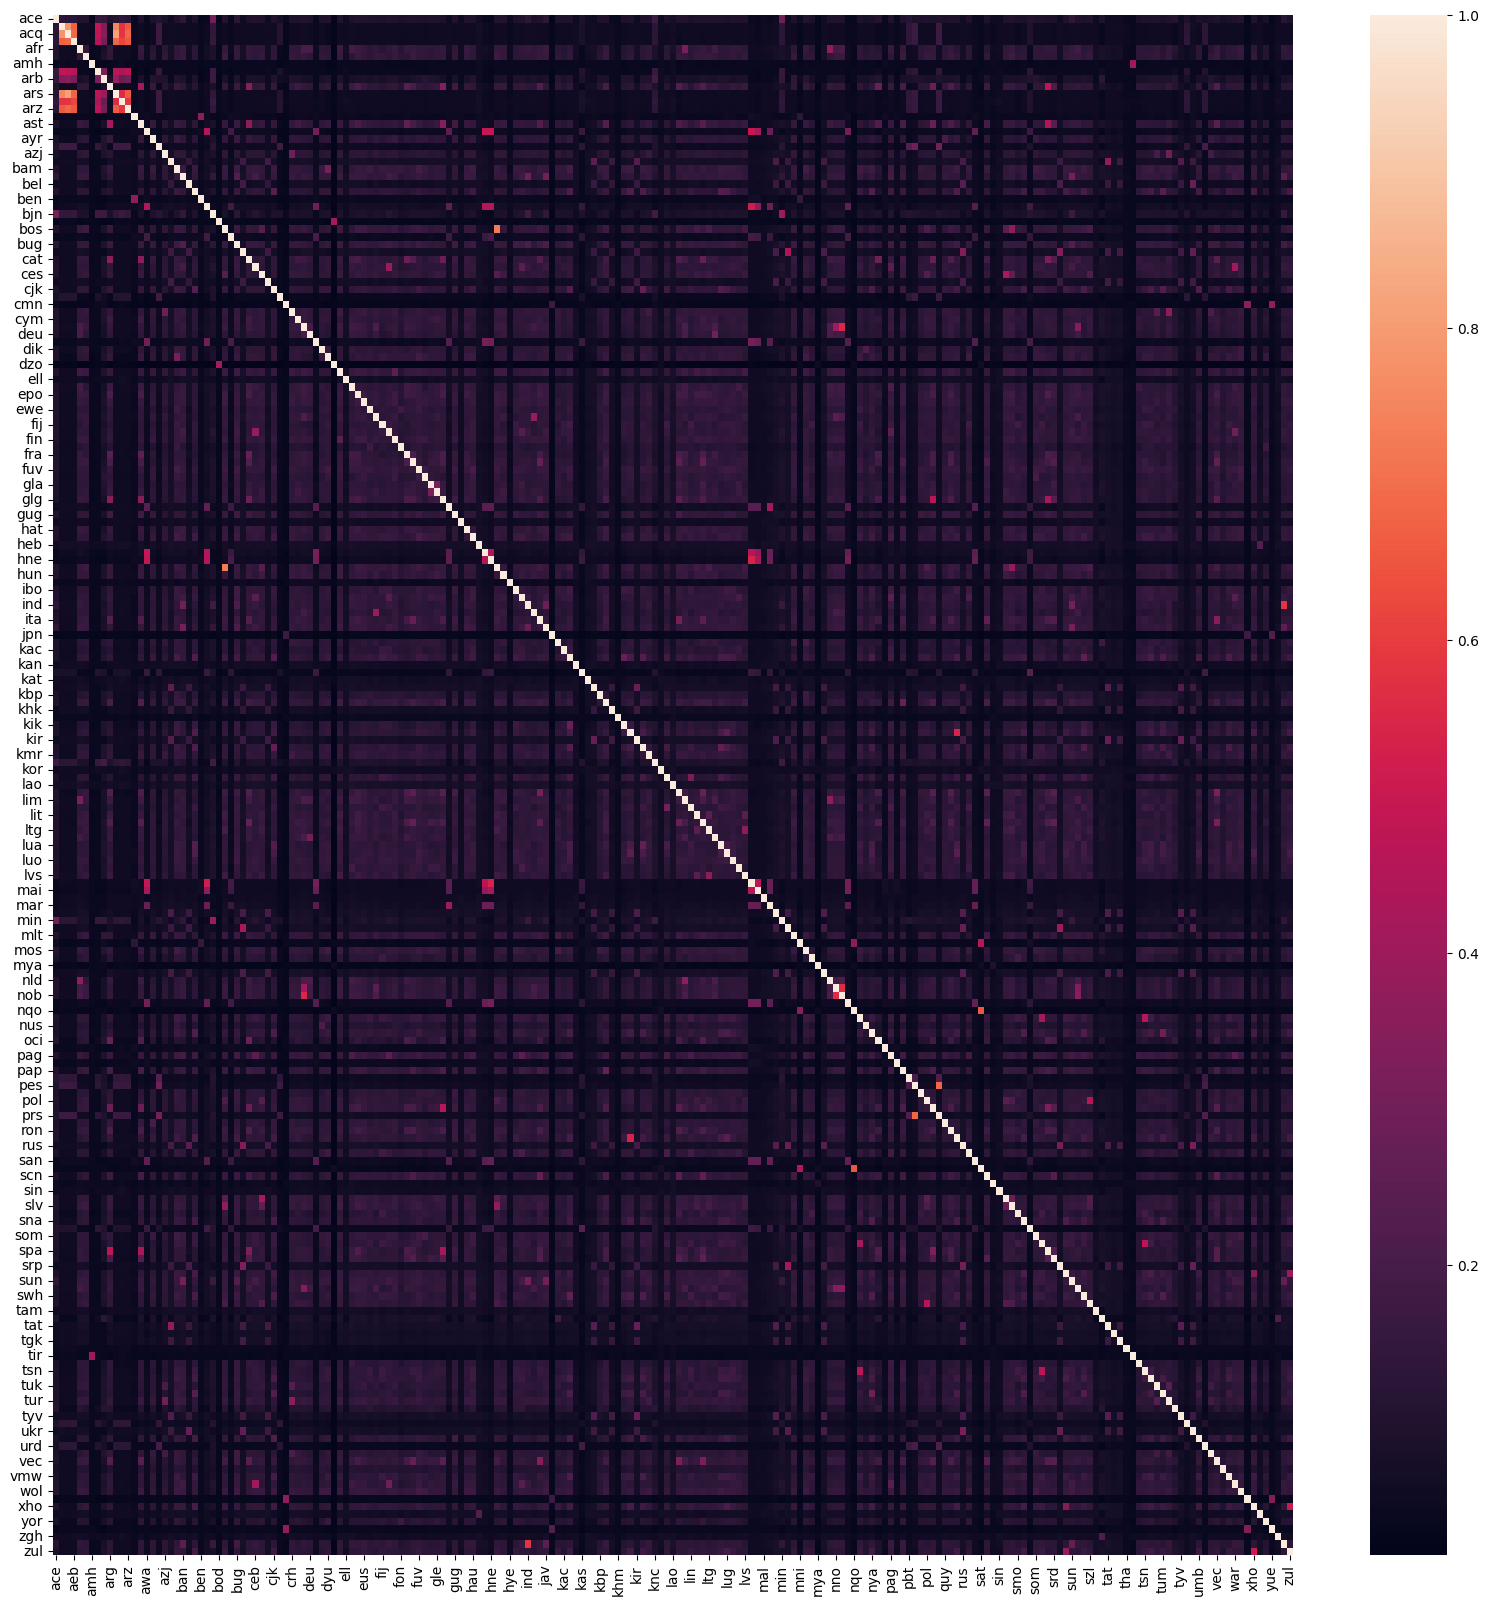

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

langs = list(combined.keys())
array = [[counter_based_iou(combined[lang1], combined[lang2]) for lang2 in langs] for lang1 in tqdm(langs)]
df_cm = pd.DataFrame(array, index = [i for i in langs],
                  columns = [i for i in langs])
plt.figure(figsize = (20, 20))
sn.heatmap(df_cm, annot=False)

Looking to the most simmilar languages to tat, kaz, mhr, rus

In [10]:
df_cm['mhr'].sort_values(ascending=False).head(20)

mhr    1.000000
rus    0.228266
tyv    0.223153
tat    0.218315
myv    0.216577
kir    0.213883
chv    0.202098
bak    0.199725
bul    0.195228
mkd    0.186139
kaz    0.185365
srp    0.183674
ukr    0.180509
tgk    0.168149
bel    0.162357
khk    0.158167
ind    0.083203
ssw    0.082267
xho    0.082223
zul    0.081564
Name: mhr, dtype: float64

In [11]:
df_cm['kaz'].sort_values(ascending=False).head(20)

kaz    1.000000
kir    0.274896
bak    0.251762
tat    0.230572
tyv    0.222144
mhr    0.185365
rus    0.174423
ukr    0.174353
myv    0.172880
tgk    0.164570
bel    0.162735
bul    0.161609
srp    0.158243
chv    0.154882
mkd    0.152257
khk    0.149990
eng    0.079802
nob    0.079520
ind    0.079384
sun    0.078792
Name: kaz, dtype: float64

In [12]:
df_cm['tat'].sort_values(ascending=False).head(20)

tat    1.000000
bak    0.375766
kir    0.269212
tyv    0.244218
kaz    0.230572
mhr    0.218315
myv    0.198151
rus    0.196358
bul    0.182403
chv    0.181577
srp    0.171563
tgk    0.168314
ukr    0.168031
mkd    0.166880
bel    0.158920
khk    0.156034
eng    0.084873
ind    0.084577
sun    0.083157
dan    0.082432
Name: tat, dtype: float64

In [13]:
df_cm['rus'].sort_values(ascending=False).head(20)

rus    1.000000
bul    0.337529
ukr    0.317711
srp    0.295797
mkd    0.271054
bel    0.232080
myv    0.230977
mhr    0.228266
tyv    0.201336
tat    0.196358
chv    0.194341
bak    0.193727
kir    0.186825
tgk    0.186451
kaz    0.174423
khk    0.151492
lvs    0.082998
fao    0.082504
dan    0.082010
ltg    0.081825
Name: rus, dtype: float64

In [14]:
for key, val in (combined['tat'] & combined['kaz']).most_common(50):
    print(model.tokenizer.decode(key), ':', val)

. : 1115
</s> : 997
 : 911
, : 786
0 : 226
- : 185
1 : 172
у : 167
ы : 143
н : 143
ның : 143
да : 113
2 : 112
п : 106
к : 102
а : 92
р : 86
( : 81
9 : 78
е : 76
ге : 74
бар : 72
да : 72
ын : 68
) : 66
лар : 64
та : 63
3 : 61
с : 61
5 : 61
4 : 59
м : 59
дан : 55
т : 54
6 : 53
й : 53
ында : 50
я : 49
сы : 49
8 : 49
т : 43
не : 41
д : 41
су : 40
лы : 39
ып : 38
нан : 38
ына : 37
ел : 37
7 : 37


# Tokenizer efficiency for MadLad400

In [15]:
import transformers
import tokenizers as hf_tokenizers


def measure_efficiency(lang: str, tokenizer):
    combined = defaultdict(list)
    for row in flores.to_dict('records'):
        if row['iso_639_3'] != lang:
            continue
        if isinstance(tokenizer, transformers.models.t5.tokenization_t5_fast.T5TokenizerFast):
            combined[row['iso_639_3']].append(list(map(model.tokenizer.decode, model.tokenizer(row["text"])['input_ids'])))
        elif isinstance(tokenizer, hf_tokenizers.Tokenizer):
            combined[row['iso_639_3']].append(tokenizer.encode(row["text"]).tokens)
        else:
            raise NotImplemented('Unknown tokenizer')


    df = pd.DataFrame()
    for lang in combined.keys():
        df[lang] = combined[lang]

    return df[lang].apply(lambda tokenized: sum(list(map(len, tokenized))) / len(tokenized)).mean()

In [16]:
# from collections import Counter, defaultdict
# from tqdm import tqdm

# combined = defaultdict(list)
# for row in tqdm(flores.to_dict('records')):
#     combined[row['iso_639_3']].append(list(map(model.tokenizer.decode, model.tokenizer(row["text"])['input_ids'])))

# for key in list(combined.keys()):
#     if len(combined[key]) != 997:
#         del combined[key]

# langs = list(combined.keys())
# df = pd.DataFrame()
# for lang in langs:
#     df[lang] = combined[lang]

In [17]:
measure_efficiency('mhr', model.tokenizer)

2.9796227559254294

In [18]:
measure_efficiency('kaz', model.tokenizer)

3.0971802925985155

In [19]:
measure_efficiency('tat', model.tokenizer)

3.072161000794257

In [20]:
measure_efficiency('rus', model.tokenizer)

2.980015697194642

# Token efficiency for custom BPE (30k)

In [21]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Digits
from tokenizers import pre_tokenizers


from tokenizers.pre_tokenizers import Whitespace


def make_tokenizer(files: list[str]):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
    pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=True)])
    tokenizer.pre_tokenizer = pre_tokenizer
    tokenizer.train(files, trainer)
    return tokenizer

In [22]:
from scripts.helpers import path_manager
dm = path_manager.DatasetManager()

mhr_tokenizer = make_tokenizer([dm.get_path('mhr', 'mari-monolingual-1.4m.csv')])
# tat_tokenizer = make_tokenizer()
kaz_tokenizer = make_tokenizer([dm.get_path('kaz', f'multidomain-15.5m.csv')])

print(mhr_tokenizer.get_vocab_size())
# print(tat_tokenizer.get_vocab_size())
print(kaz_tokenizer.get_vocab_size())

30000
30000


In [23]:
measure_efficiency('mhr', mhr_tokenizer)

3.864727177855686

In [24]:
measure_efficiency('kaz', kaz_tokenizer)

4.38621870039817

# Find differences between our tokenizer & madlad's